# Training a variational autoencoder (VAE) neural network with stochastic quantization model

Importing all required third-party dependencies

In [1]:
import os
import itertools
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib as mpl
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import sq.optim as sq_optim
import sq.quantization as sq

Choosing a different algorithm for convolutions computations

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

To enforce reproducibility we set the random seed manually

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 42


We set up the computation device for performing optimization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

We will use MNIST dataset of handwritten digits

In [5]:
EPOCHS = 50

BATCH_TRAIN = 512
BATCH_TEST = 512
DATA_DIR = '../../data/'
RESULTS_DIR = '../../results/'

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

These are examples of handwritten digits from the dataset

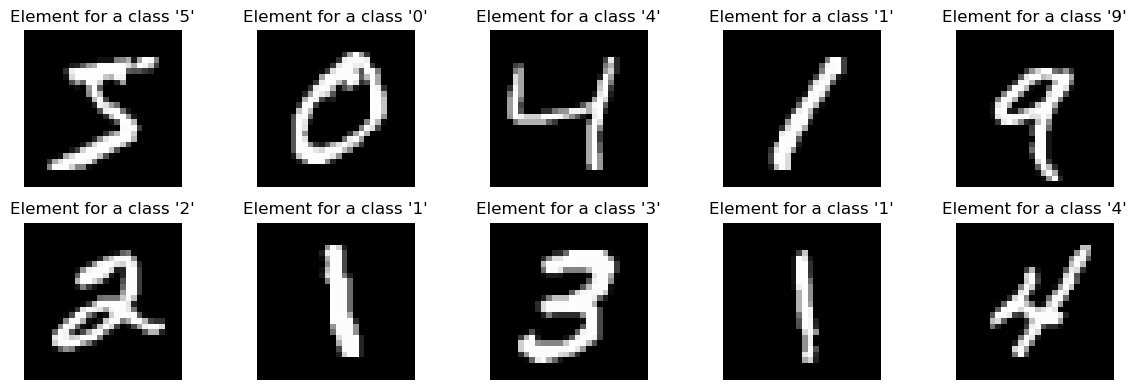

In [6]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_dataset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Show the plot
plt.show()

A blueprint for a convolutional variational autoencoder neural network

In [7]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ELU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ELU(),

            nn.Flatten(),

            nn.Linear(128 * 4 * 4, 1024),
            nn.ELU(),

            nn.Linear(1024, 256),
            nn.ELU(),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256)

        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ELU(),

            nn.Linear(1024, 128 * 4 * 4),
            nn.ELU(),

            nn.Unflatten(1, (128, 4, 4)),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ELU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ELU(),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Output dimensions of the decoder network should match the input tensor, to ensure the compatibility of input and output dimensions we will display these tensors on the grid. For untrained network, decoder output is a random noise.

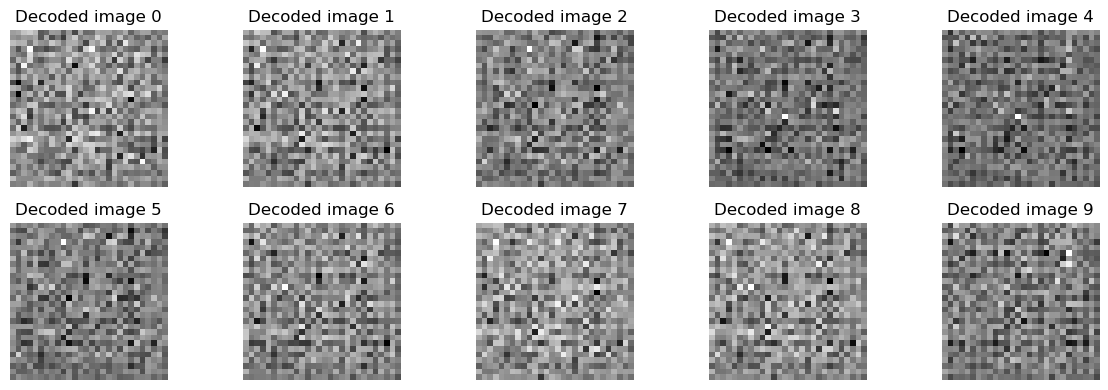

In [8]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + beta * KLD) / x.size(0)  # Normalize by batch size


LATENT_DIM = 2

autoenc_model = ConvVAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(autoenc_model.parameters(), lr=1e-3, weight_decay=1e-05)

images, labels = next(iter(test_dataloader))
fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

with torch.no_grad():
    output, _, _ = autoenc_model(images.to(device))

    for i, image in enumerate(itertools.islice(output, 2 * row_elements)):
        row = i // row_elements
        col = i % row_elements
    
        axes[row, col].imshow(image.cpu().detach().numpy().squeeze(), cmap="gray")
        axes[row, col].set_title(f"Decoded image {i}")
        axes[row, col].axis("off")

plt.show()

Training an instantiated Convolutional Autoencoder

In [9]:
train_loss, val_loss = [], []


for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_val_loss = []

    # Training loss and accuracy
    autoenc_model.train()

    for images, _ in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)

        # Forward pass
        optimizer.zero_grad()

        outputs, mu, logvar = autoenc_model(images)
        loss = vae_loss_function(outputs, images, mu, logvar, beta=2.0)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_train_loss.append(loss.item())
        progress_bar.set_description(f"Train loss: {loss.item():.2f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))

    # Validation loss and accuracy
    autoenc_model.eval()

    with torch.no_grad():
        for images, _ in test_dataloader:
            images = images.to(device)

            outputs, mu, logvar = autoenc_model(images)
            loss = vae_loss_function(outputs, images, mu, logvar)

            epoch_val_loss.append(loss.item())

    val_loss.append(np.mean(np.array(epoch_val_loss)))

    print(f"Validation loss: {loss.item():.2f}")

Train loss: 173.46: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 27.95it/s]


Validation loss: 174.60


Train loss: 165.91: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.72it/s]


Validation loss: 159.27


Train loss: 151.40: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.86it/s]


Validation loss: 155.99


Train loss: 156.38: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.80it/s]


Validation loss: 152.12


Train loss: 151.23: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.68it/s]


Validation loss: 150.78


Train loss: 158.84: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.08it/s]


Validation loss: 142.01


Train loss: 141.11: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.56it/s]


Validation loss: 147.66


Train loss: 150.57: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.86it/s]


Validation loss: 147.08


Train loss: 151.06: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.01it/s]


Validation loss: 146.76


Train loss: 143.36: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.60it/s]


Validation loss: 142.68


Train loss: 150.39: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 29.39it/s]


Validation loss: 148.31


Train loss: 156.57: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.23it/s]


Validation loss: 148.28


Train loss: 149.37: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.01it/s]


Validation loss: 143.88


Train loss: 138.10: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.12it/s]


Validation loss: 144.54


Train loss: 141.91: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.48it/s]


Validation loss: 139.71


Train loss: 144.12: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.80it/s]


Validation loss: 144.69


Train loss: 136.32: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.98it/s]


Validation loss: 139.48


Train loss: 143.33: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.84it/s]


Validation loss: 138.13


Train loss: 150.29: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.14it/s]


Validation loss: 145.35


Train loss: 141.58: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 29.50it/s]


Validation loss: 142.11


Train loss: 148.79: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.19it/s]


Validation loss: 141.55


Train loss: 140.96: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.69it/s]


Validation loss: 143.26


Train loss: 139.47: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.82it/s]


Validation loss: 138.40


Train loss: 146.55: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.56it/s]


Validation loss: 140.91


Train loss: 147.74: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.11it/s]


Validation loss: 138.78


Train loss: 143.97: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.77it/s]


Validation loss: 141.25


Train loss: 145.59: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.51it/s]


Validation loss: 139.94


Train loss: 144.56: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.33it/s]


Validation loss: 142.14


Train loss: 145.47: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 29.20it/s]


Validation loss: 137.41


Train loss: 146.94: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.58it/s]


Validation loss: 142.99


Train loss: 146.47: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.30it/s]


Validation loss: 129.93


Train loss: 141.47: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.81it/s]


Validation loss: 142.13


Train loss: 138.92: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 29.30it/s]


Validation loss: 139.94


Train loss: 152.15: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.68it/s]


Validation loss: 139.49


Train loss: 146.56: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.05it/s]


Validation loss: 139.74


Train loss: 145.60: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.42it/s]


Validation loss: 138.91


Train loss: 142.51: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.81it/s]


Validation loss: 138.74


Train loss: 138.89: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.85it/s]


Validation loss: 135.41


Train loss: 140.87: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.95it/s]


Validation loss: 142.02


Train loss: 145.35: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.93it/s]


Validation loss: 141.18


Train loss: 140.36: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.04it/s]


Validation loss: 138.13


Train loss: 148.45: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.80it/s]


Validation loss: 136.50


Train loss: 137.62: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.92it/s]


Validation loss: 135.85


Train loss: 136.06: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.76it/s]


Validation loss: 135.81


Train loss: 144.19: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.64it/s]


Validation loss: 142.10


Train loss: 149.70: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.80it/s]


Validation loss: 140.86


Train loss: 150.82: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.99it/s]


Validation loss: 137.06


Train loss: 145.21: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.84it/s]


Validation loss: 138.22


Train loss: 139.84: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.81it/s]


Validation loss: 137.37


Train loss: 151.96: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.76it/s]


Validation loss: 136.43


We compare train and validation losses to detect the overfitting of the model

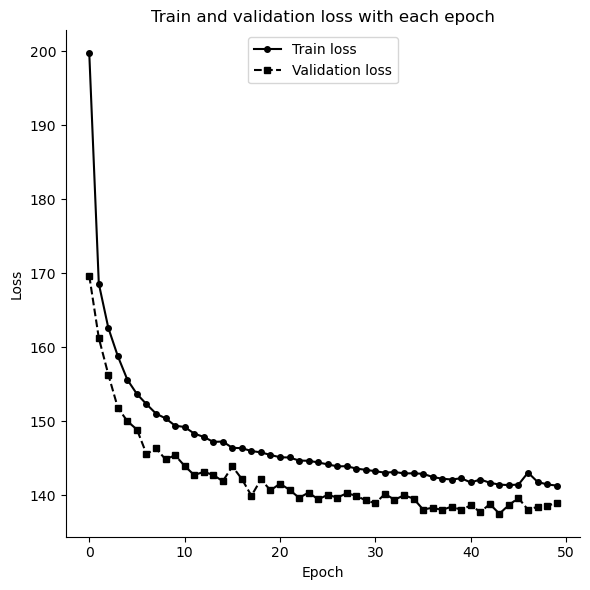

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

ax.plot(range(len(train_loss)), train_loss, linestyle='-',
           marker='o', color='k', markersize=4, label="Train loss")
ax.plot(range(len(val_loss)), val_loss, linestyle='--',
           marker='s', color='k', markersize=4, label="Validation loss")

ax.set_title("Train and validation loss with each epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc="upper center")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.show()

The decoder network outputs resemble an input data, which means encoder-decoder pair formed a bijective mapping from a discrete handwritten digit set, into a metric latent space

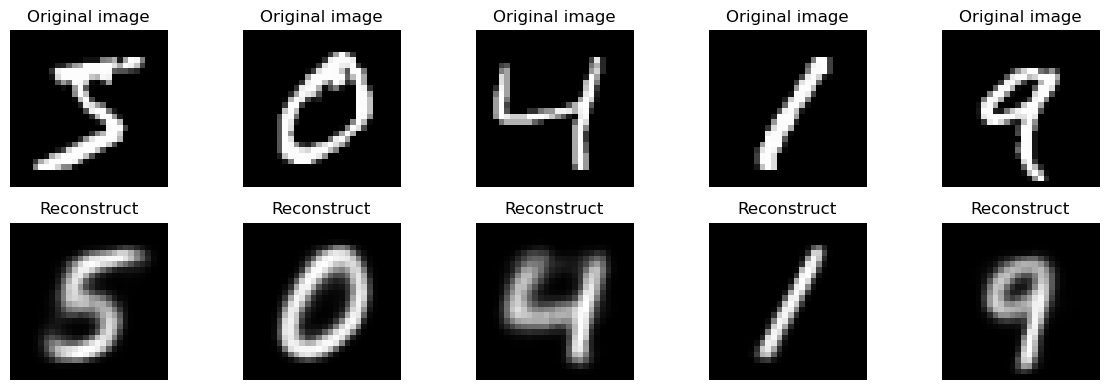

In [11]:
autoenc_model.eval()

row_elements = 5
fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

with torch.no_grad():
    for i, (image, label) in enumerate(
        itertools.islice(train_dataset, row_elements)
    ):
        axes[0, i].imshow(image.squeeze(), cmap="gray")
        axes[0, i].set_title(f"Original image")
        axes[0, i].axis("off")

        inp_image = image.reshape((1, 1, 28, 28)).to(device)

        output, _, _ = autoenc_model(inp_image)
        reconst_image = output.reshape((1, 28, 28)).cpu()

        axes[1, i].imshow(reconst_image.squeeze(), cmap="gray")
        axes[1, i].set_title(f"Reconstruct")
        axes[1, i].axis("off")

plt.show()

We convert all handwritten digits from the dataset to visualize their embeddings in the metric space

In [12]:
def group_embeddings_by_label(model: nn.Module, dataloader: DataLoader):
    all_embeddings = np.empty((0, LATENT_DIM))
    grouped_embeddings = {i: np.empty((0, LATENT_DIM)) for i in range(10)}

    for img, lbs in dataloader:
        model_device = next(model.parameters()).device
        batch_mu, _ = model.encode(img.to(model_device))
        batch_embeddings = batch_mu.cpu().detach().numpy()

        lbs = lbs.detach().numpy()

        for emb, lb in zip(batch_embeddings, lbs):
            grouped_embeddings[lb] = np.vstack((grouped_embeddings[lb], np.array(emb)))

    for cl, embeds in grouped_embeddings.items():
        all_embeddings = np.vstack((all_embeddings, np.array(embeds)))

    return grouped_embeddings, all_embeddings


with torch.no_grad():
    train_group_embeds, train_all_embeds = group_embeddings_by_label(autoenc_model, train_dataloader)
    test_group_embeds, test_all_embeds = group_embeddings_by_label(autoenc_model, test_dataloader)

We compare the low-level representations distribution on the 2D scatter plot

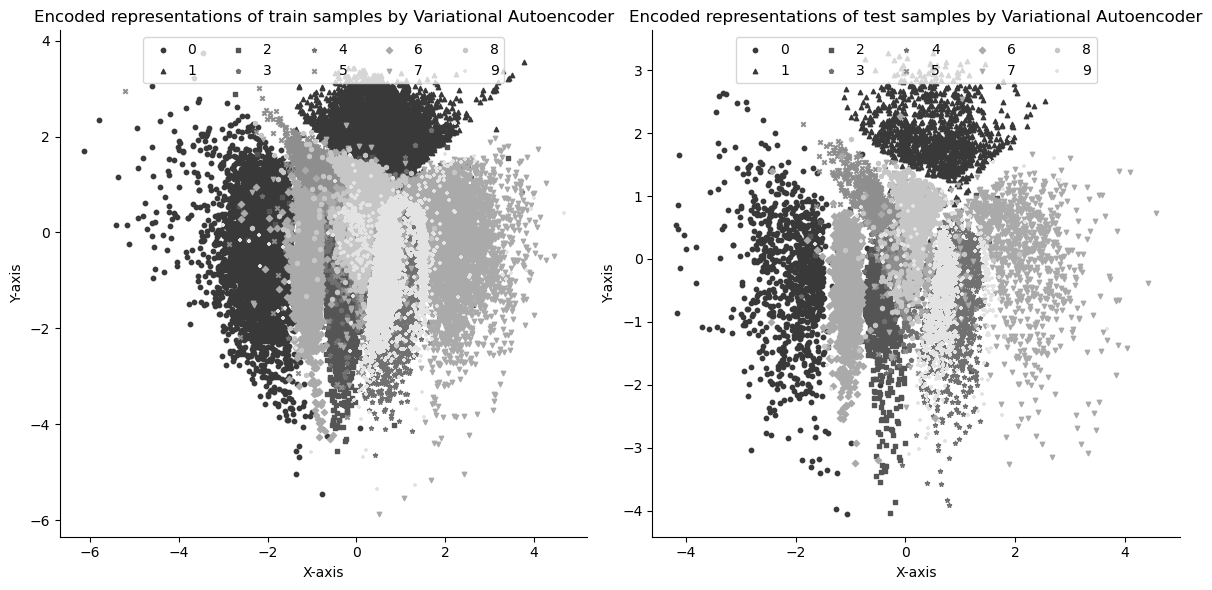

In [13]:
markers = ['o', '^', 's', 'p', '*', 'x', 'D', 'v', 'h', '+']
markers_color = mpl.colormaps['gray'].resampled(len(markers))
markers_color_range = np.linspace(0.2, 0.8, len(markers))
marksize = 10

fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

for idx, (cls, embeds) in enumerate(train_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax[0].scatter(embeds[:, 0], embeds[:, 1], color=cls_color, label=cls,
                  alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax[0].legend(loc="upper center", ncol=5)
ax[0].set_title('Encoded representations of train samples by Variational Autoencoder')

ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

for idx, (cls, embeds) in enumerate(test_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax[1].scatter(embeds[:, 0], embeds[:, 1], color=cls_color, label=cls, alpha=1.0,
                  s=marksize, marker=markers[idx % len(markers)])

ax[1].legend(loc="upper center", ncol=5)
ax[1].set_title('Encoded representations of test samples by Variational Autoencoder')

ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.show()

An autoencoder model is usually applied in the context of unsupervised learning to create low level representations of unlabeled data, then an algorithm of unsupervised classification performs a grouping of these representations in some metric space. We will use stochastic quantization algorithm for the non-convex optimization problem of representations clustering

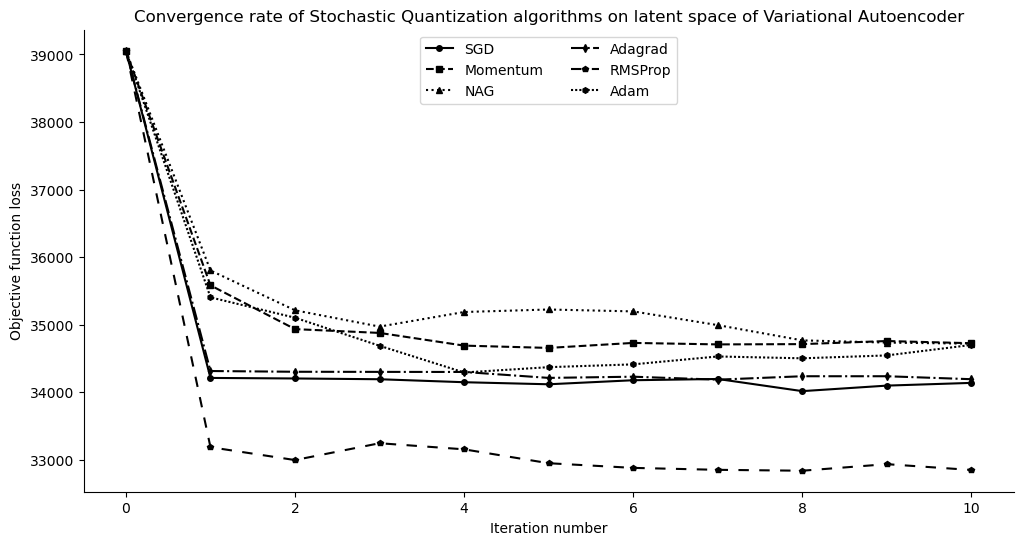

In [14]:
SQ_ITERS = 10

sq_algorithms = {
    "SGD": sq.StochasticQuantization(sq_optim.SGDOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Momentum": sq.StochasticQuantization(sq_optim.MomentumOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                          learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "NAG": sq.StochasticQuantization(sq_optim.NAGOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "Adagrad": sq.StochasticQuantization(sq_optim.AdagradOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         learning_rate=0.5, random_state=np.random.RandomState(RANDOM_SEED)),
    "RMSProp": sq.StochasticQuantization(sq_optim.RMSPropOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         random_state=np.random.RandomState(RANDOM_SEED)),
    "Adam": sq.StochasticQuantization(sq_optim.AdamOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                      learning_rate=0.01, random_state=np.random.RandomState(RANDOM_SEED))
}

markers = [('o', '-'), ('s', '--'), ('^', ':'), ('d', '-.'), ('p', (0, (5, 5))), ('h', (0, (1, 1)))]
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    marker, linestyle = markers[idx % len(markers)]

    alg = alg.fit(train_all_embeds)

    ax.plot(range(len(alg.loss_history_)), alg.loss_history_,
            linestyle=linestyle, marker=marker, color='k',
            markersize=4, label=name)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Convergence rate of Stochastic Quantization algorithms on latent space of Variational Autoencoder")
plt.xlabel('Iteration number')
plt.ylabel('Objective function loss')
plt.legend(loc="upper center", ncol=2)
plt.show()

We use confusion matrix to compare the accuracy of classification model for each class

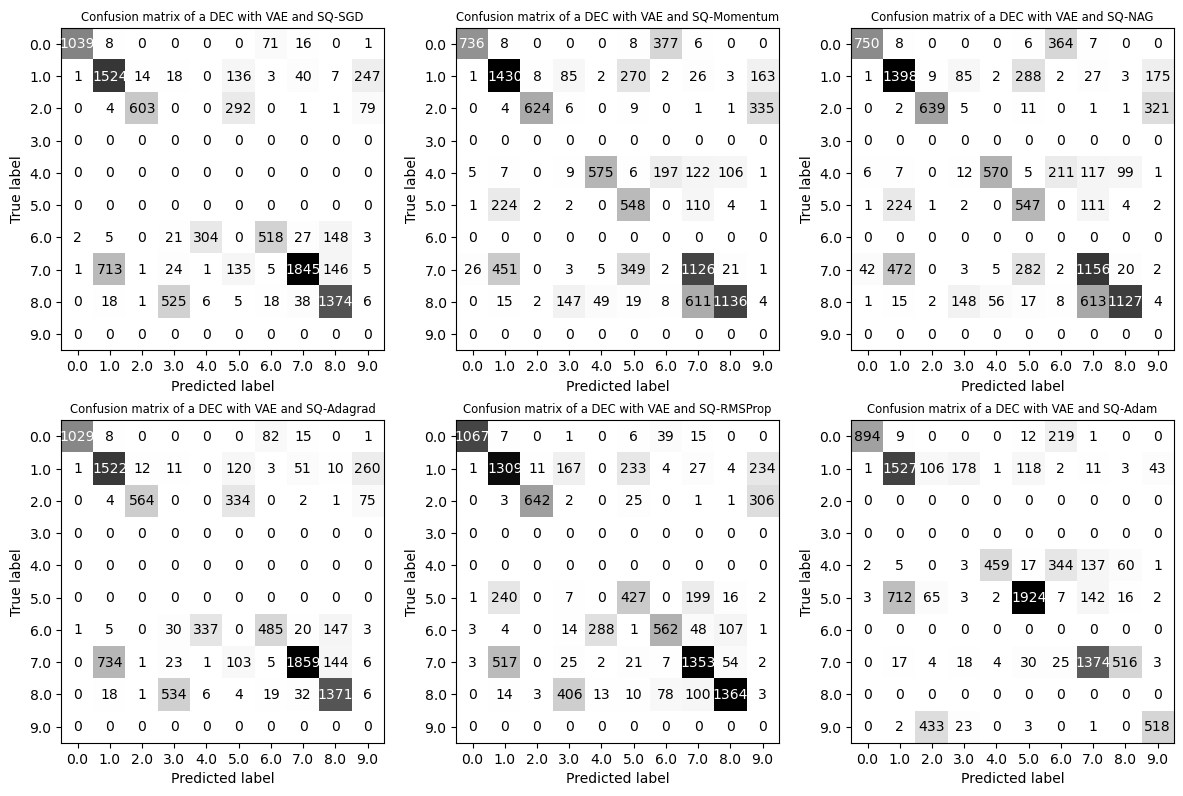

In [15]:
n_col, n_row = (2, 3)
fig, ax = plt.subplots(n_col, n_row, figsize=(12, 8), tight_layout=True)
f1_scores = {}

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    y_true, y_pred = np.array([]), np.array([])

    for _, embs in test_group_embeds.items():
        cls = alg.predict(embs)
        cls_predicted = np.bincount(cls).argmax()

        y_true = np.append(y_true, np.full((1, len(embs)), cls_predicted))
        y_pred = np.append(y_pred, cls)

    ax_idx = ax[idx // n_row, idx % n_row]

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap="Greys", colorbar=False, ax=ax_idx
    )

    ax_idx.set_title(f"Confusion matrix of a DEC with VAE and SQ-{name}", size="small")
    f1_scores[name] = f1_score(y_true, y_pred, average="weighted")

plt.show()

To account for label imbalance in the test set, we choose a weighted F1 score as an accuracy metric.

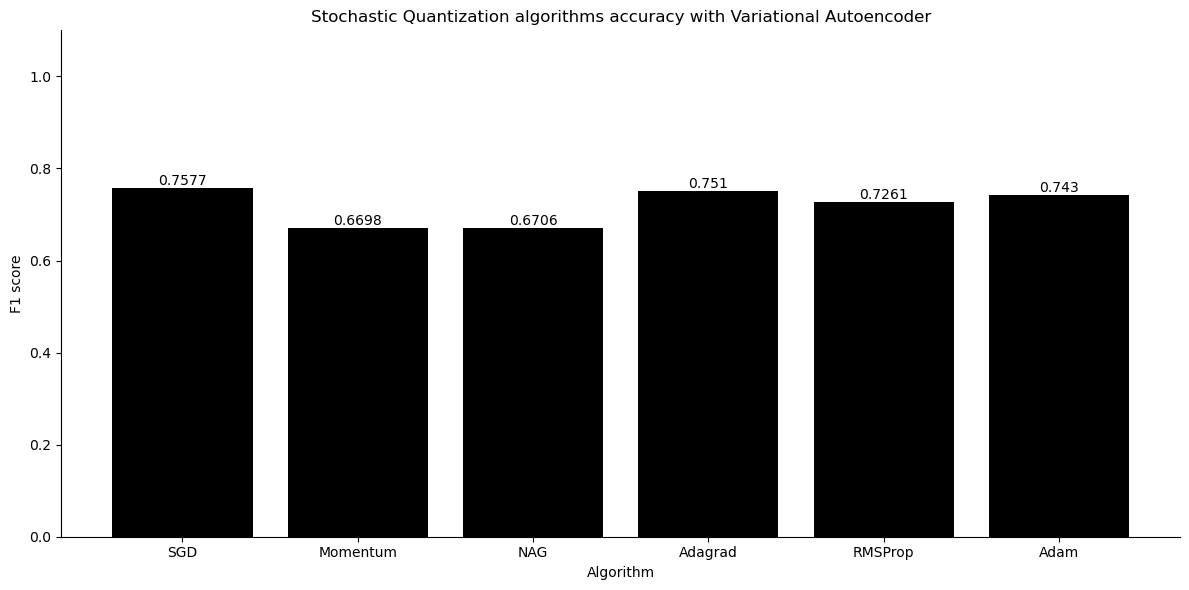

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

bars = ax.bar(f1_scores.keys(), f1_scores.values(), color='k')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0,
            height, f'{round(height, 4)}', ha='center', va='bottom')

ax.set_xlabel("Algorithm")
ax.set_ylabel("F1 score")
ax.set_title("Stochastic Quantization algorithms accuracy with Variational Autoencoder")
ax.set_ylim(top=1.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Save encoder model for the later use

In [17]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

autoenc_model.eval()

torch.save(autoenc_model.state_dict(), os.path.join(MODEL_DIR, "vae.bin"))